In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

In [2]:
shots_df = pd.read_csv("data/NBA_2004_2024_Shots.csv")

In [3]:
def season_to_df(season):
    return shots_df[shots_df['SEASON_1']==season]

In [4]:
team_name_to_ABB = {
    "Atlanta Hawks":"ATL",
	"Boston Celtics":"BOS",
	"Brooklyn Nets":"BKN",
	"Charlotte Hornets":"CHA",
	"Chicago Bulls":"CHI",
	"Cleveland Cavaliers":"CLE",
	"Dallas Mavericks":"DAL",
	"Denver Nuggets":"DEN",
	"Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
	"Houston Rockets":"HOU",
	"Indiana Pacers":"IND",
	"Los Angeles Clippers":"LAC",
	"Los Angeles Lakers":"LAL",
	"Memphis Grizzlies":"MEM",
	"Miami Heat":"MIA",
	"Milwaukee Bucks":"MIL",
	"Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
	"Oklahoma City Thunder":"OKC",
	"Orlando Magic":"ORL",
	"Philadelphia 76ers":"PHI",
	"Phoenix Suns":"PHX",
	"Portland Trail Blazers":"PHX",
	"Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
	"Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
	"Washington Wizards":"WAS"
}

In [5]:
class MakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values,dtype=torch.float32)
        self.labels = torch.tensor(labels.values,dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [6]:
category_sizes = []
label_to_one_hot = ["ACTION_TYPE","BASIC_ZONE","ZONE_NAME"]

for categorical_var in label_to_one_hot:
    category_sizes.append(range(shots_df[categorical_var].unique().shape[0]))

In [7]:
def shots_data_processing(df):
    #select columns, label encoding
    df_condensed = df[["PLAYER_ID","HOME_TEAM","ACTION_TYPE","SHOT_TYPE","BASIC_ZONE","ZONE_NAME","LOC_X","LOC_Y","SHOT_DISTANCE","QUARTER"]]
    df_outcome = df["SHOT_MADE"]
    df_condensed.loc[:,"HOME_TEAM"] = (df["TEAM_NAME"].map(team_name_to_ABB)==df["HOME_TEAM"])
    df_condensed.loc[:,"TIME_LEFT"] = (df["MINS_LEFT"]*60+df["SECS_LEFT"])
    df_condensed["HOME_TEAM"] = df_condensed["HOME_TEAM"].astype(int)
    for category in df_condensed.keys():
        if not (df_condensed[category].dtype in [int,float]):
            tmp_dict = {k:i for i,k in enumerate(sorted(df[category].unique()))}
            df_condensed.loc[:,category] = df_condensed[category].map(tmp_dict)

    #label encoding -> one-hot encoding
    encoder = OneHotEncoder(categories=category_sizes,sparse_output=False, dtype="float32",handle_unknown='error')
    one_hot_encoded = encoder.fit_transform(df_condensed[label_to_one_hot])
    encoded_df = pd.DataFrame(
        one_hot_encoded,
        columns=encoder.get_feature_names_out(label_to_one_hot),
        index=df.index
    )
    df_condensed = pd.concat([df_condensed.drop(columns=label_to_one_hot), encoded_df], axis=1)

    #temp drop
    df_condensed_drop = df_condensed.drop(columns=["PLAYER_ID"])

    #scaling to [-1,1]
    def scaling_func(x):
        if not (x.max() == 1 and x.min() == 0):
            return 2 * (x - x.min()) / (x.max() - x.min()) - 1
        return x
    df_condensed_drop_scaled = df_condensed_drop.apply(scaling_func).astype("float32")

    df_condensed_drop_scaled = df_condensed_drop_scaled.fillna(0)

    return MakeDataset(df_condensed_drop_scaled,df_outcome)

In [8]:
train_data = season_to_df(2024).sample(frac=0.9)
dev_data = season_to_df(2024).drop(train_data.index).sample(frac=0.5)
test_data = season_to_df(2024).drop(pd.concat([train_data,dev_data]).index)

processed_train_data = shots_data_processing(train_data)
processed_dev_data = shots_data_processing(dev_data)
processed_test_data = shots_data_processing(test_data)

batch_size = 32

trainloader = DataLoader(processed_train_data,batch_size=batch_size,shuffle=False)
devloader = DataLoader(processed_dev_data,batch_size=batch_size,shuffle=False)
testloader = DataLoader(processed_test_data,batch_size=batch_size,shuffle=False)

/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_81543/3195145373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed.loc[:,"TIME_LEFT"] = (df["MINS_LEFT"]*60+df["SECS_LEFT"])
/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_81543/3195145373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed["HOME_TEAM"] = df_condensed["HOME_TEAM"].astype(int)
/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_81543/3195145373.py:6: SettingWithCopyWarning: 
A value is t

In [9]:
class Model(nn.Module):
    def __init__(self,input_size):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(input_size,1)
    def forward(self,x):
        f1 = self.fc1(x)
        return f1

In [10]:
model = Model(processed_train_data[0][0].shape[0])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
arr = []
for i in tqdm(range(1000)):
    correct, total = 0, 0
    model = Model(processed_train_data[0][0].shape[0])
    with torch.no_grad():
        for data in devloader:
            features, outcome = data
            outputs = model(features)  # Raw logits
            predicted = (outputs.squeeze(-1) > 0).int()  # Threshold logits at 0
            total += outcome.size(0)
            correct += (predicted == outcome).sum().item()
        arr.append(correct / total)  # Accuracy
print(sum(arr)/len(arr), np.std(arr, ddof=1))

100%|██████████| 1000/1000 [01:03<00:00, 15.78it/s]

0.4971356195701882 0.03427132522524834


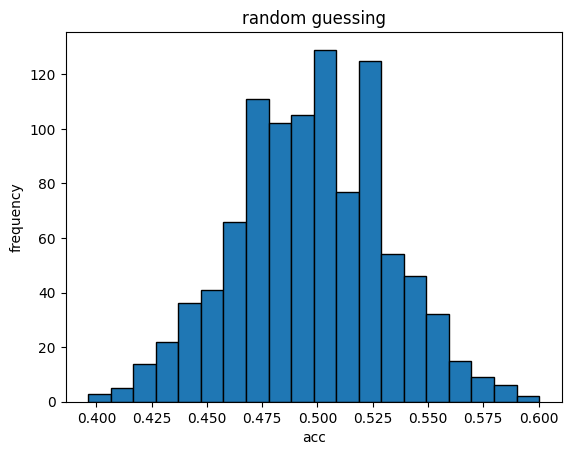

In [12]:
plt.hist(arr, bins=20, edgecolor='black')  # bins=5 specifies 5 intervals
plt.title("random guessing")
plt.xlabel("acc")
plt.ylabel("frequency")
plt.show()

In [11]:
num_epochs = 1
loss_values = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print statistics
        if i % 1000 == 999:    # print every n mini-batches
            loss_values.append(running_loss/1000)
            running_loss = 0.0

print('Finished Training')

6151it [00:03, 2042.26it/s]

Finished Training


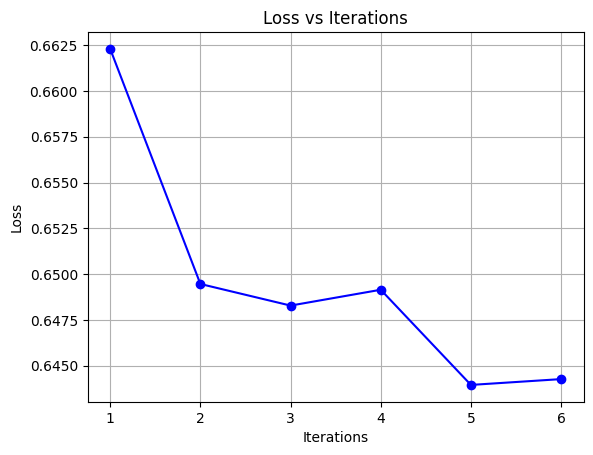

In [12]:
# Plotting the loss
# plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.plot(range(1, (len(trainloader)//1000)*num_epochs+1), loss_values, marker='o', color='b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.grid(True)
plt.show()

In [13]:
correct, total = 0, 0
with torch.no_grad():
    for data in devloader:
        features, outcome = data
        outputs = model(features)  # Raw logits
        predicted = (outputs.squeeze(-1) > 0).int()  # Threshold logits at 0
        total += outcome.size(0)
        correct += (predicted == outcome).sum().item()
    print(correct / total)  # Accuracy

0.6226794695930499


In [14]:
correct, total = 0, 0
with torch.no_grad():
    for data in testloader:
        features, outcome = data
        outputs = model(features)  # Raw logits
        predicted = (outputs.squeeze(-1) > 0).int()  # Threshold logits at 0
        total += outcome.size(0)
        correct += (predicted == outcome).sum().item()
    print(correct / total)  # Accuracy

0.6256058527663466
